In [33]:
options(warn=-1) 
library(ggplot2)
library(data.table)
library(GGally)
library(ggcorrplot)
library(forecast)
library(RcppRoll)
library(zoo)
library(lubridate)


In [2]:
setwd("C:/Users/gabri/Desktop/IE360/360 proje")

In [3]:
production <- fread("2022-06-07_production.csv")
production[, datetime:=ymd(date)+dhours(hour)]
production <- data.table(production, key = "datetime")
long_weather <- fread("2022-06-07_weather.csv")

In [4]:
wide_weather <- dcast(long_weather, date + hour ~ variable+lat+lon, var = "value")
wide_weather[, datetime:=ymd(date)+dhours(hour)]

In [5]:
wide_weather <- data.table(wide_weather, key = "datetime")
dt <- merge.data.table(wide_weather, production, all.x = TRUE, by="datetime")
dt[, date.y := NULL]
dt[, hour.y := NULL]
colnames(dt)[2] <- "date"
colnames(dt)[3] <- "hour"

dt[, CLL := rowMeans(dt[,4:12], na.rm=TRUE)]
dt[, DSWRF := rowMeans(dt[,13:21], na.rm=TRUE)]
dt[, RELH := rowMeans(dt[,22:30], na.rm=TRUE)]
dt[, TEMP := rowMeans(dt[,31:39], na.rm=TRUE)]
dt[, 4:39 := NULL]



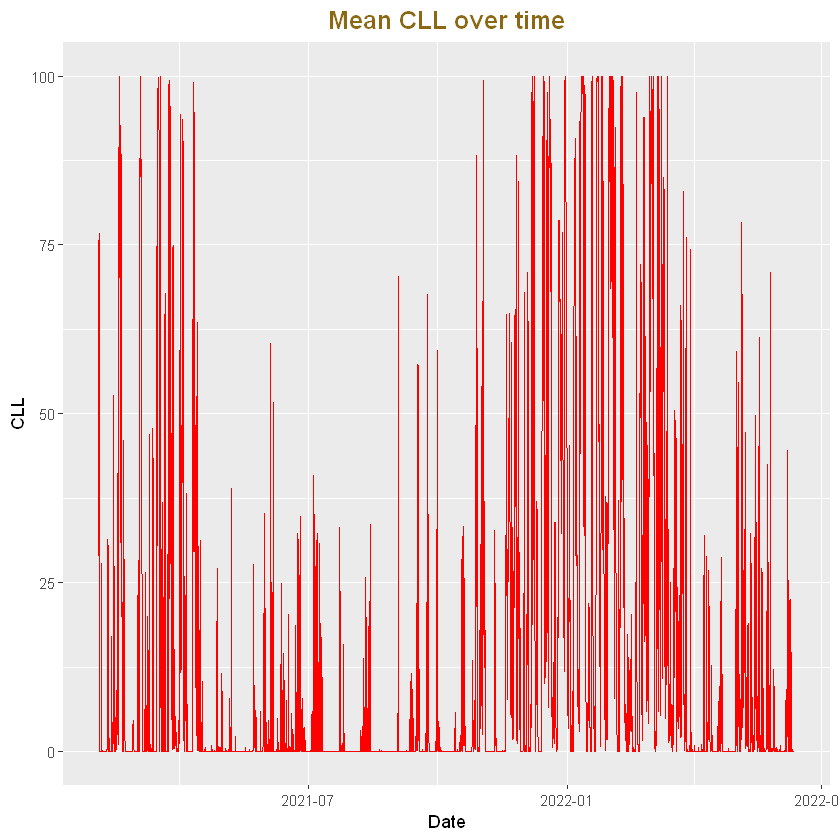

In [6]:
ggplot(dt, aes(x=datetime)) + geom_line(aes(y=CLL), color="red")+
  labs(title = "Mean CLL over time", x = "Date",y = "CLL")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))


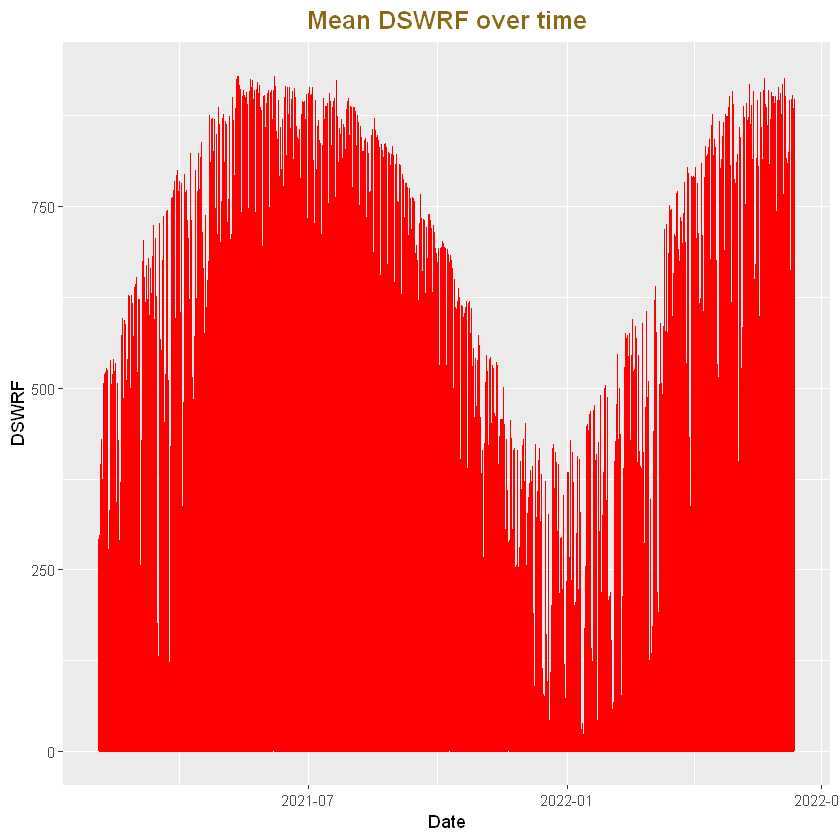

In [7]:
ggplot(dt, aes(x=datetime)) + geom_line(aes(y=DSWRF), color="red")+
  labs(title = "Mean DSWRF over time", x = "Date",y = "DSWRF")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))

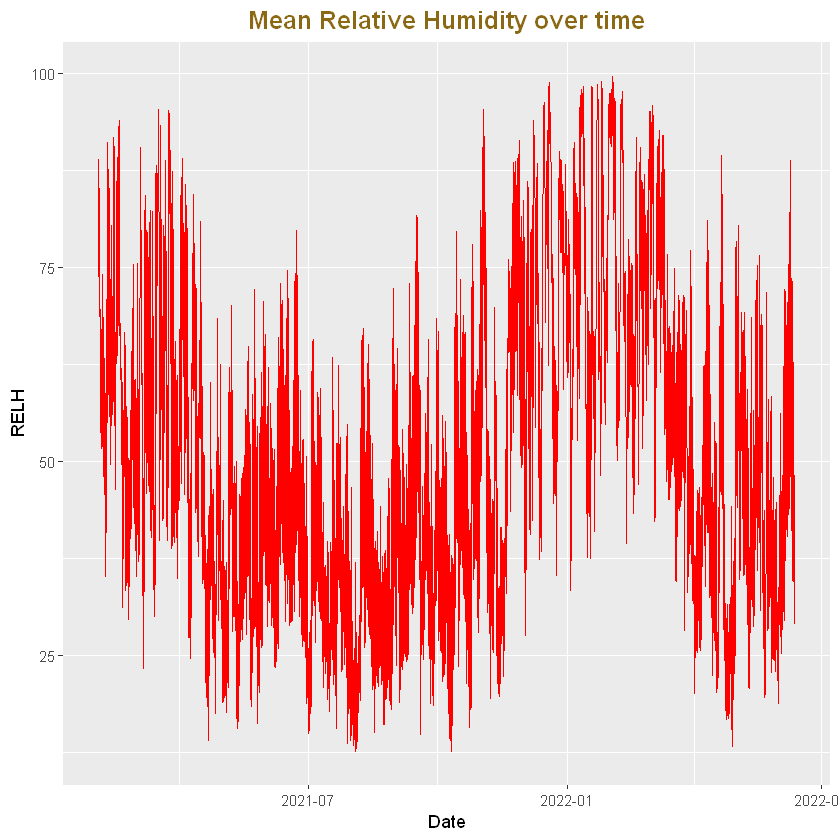

In [8]:
ggplot(dt, aes(x=datetime)) + geom_line(aes(y=RELH), color="red")+
 labs(title = "Mean Relative Humidity over time", x = "Date",y = "RELH")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))

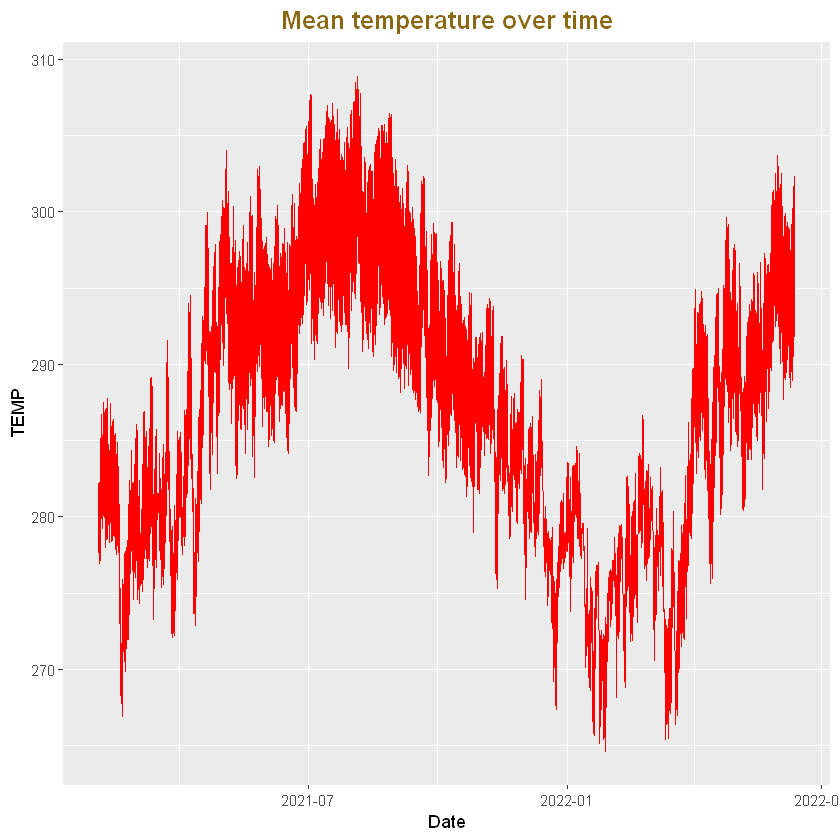

In [9]:
ggplot(dt, aes(x=datetime)) + geom_line(aes(y=TEMP), color="red")+
 labs(title = "Mean temperature over time", x = "Date",y = "TEMP")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))

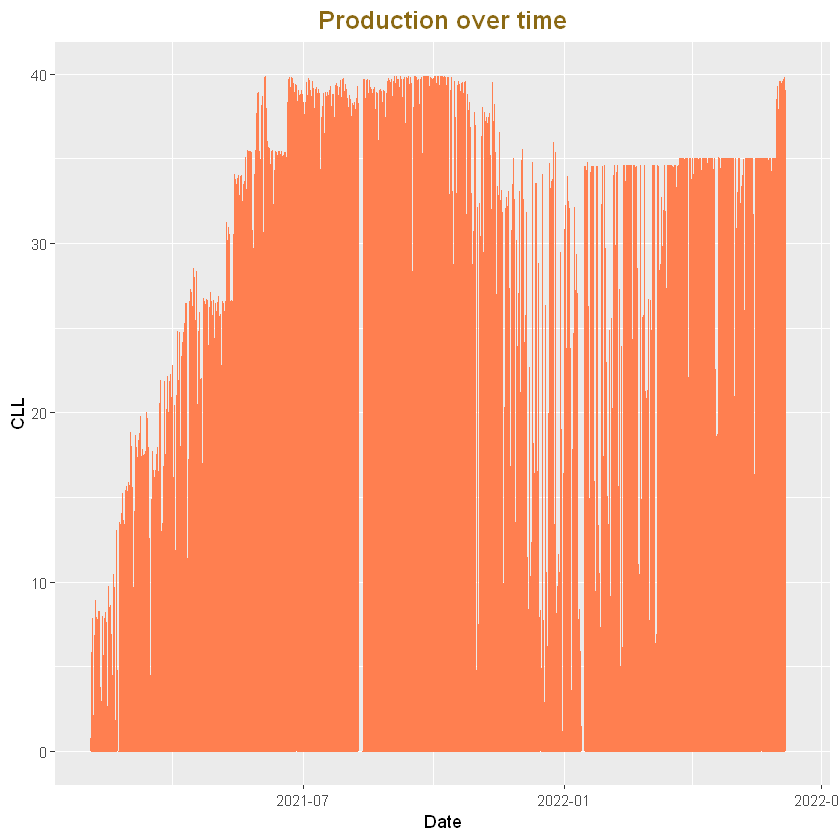

In [10]:
ggplot(dt, aes(x=datetime)) + geom_line(aes(y=production), color="coral")+
 labs(title = "Production over time", x = "Date",y = "Production")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))

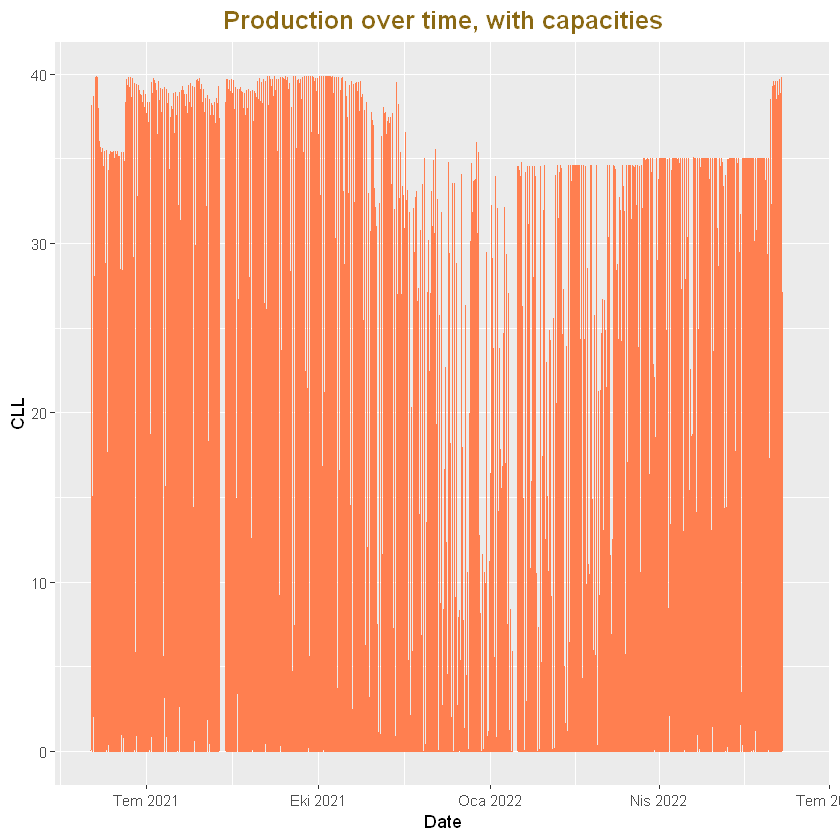

In [11]:
dt <- dt[datetime > "2021-06-01"]

ggplot(dt, aes(x=datetime)) + geom_line(aes(y=production), color="coral")+
 labs(title = "Production over time", x = "Date",y = "Production")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5))

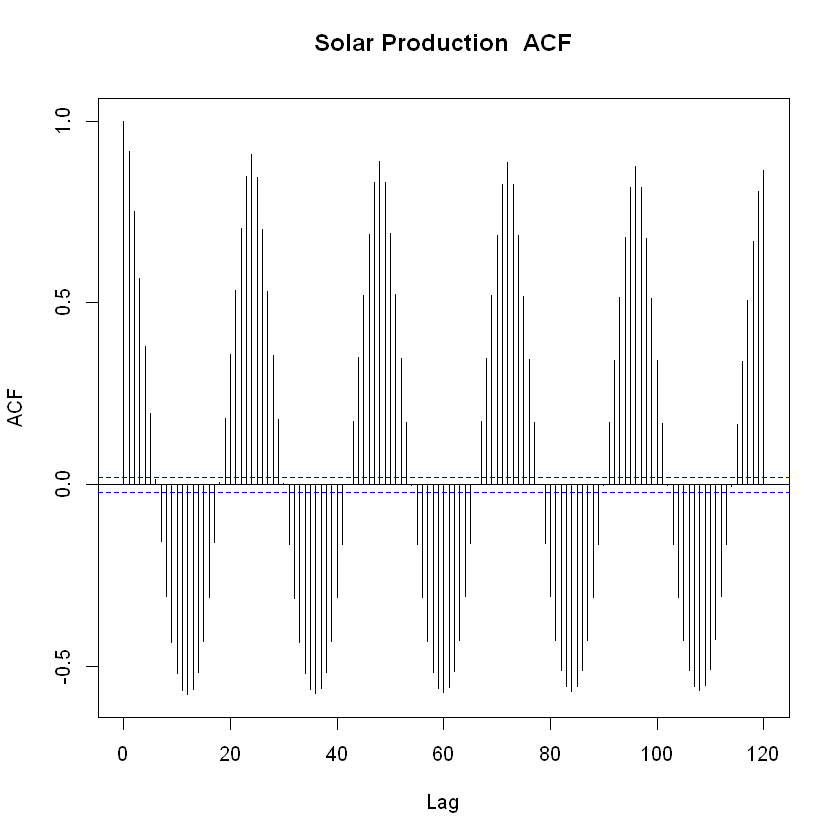

In [12]:
AutoCorrelation <- acf(dt$production, lag.max = 120,plot = FALSE, na.action = na.pass) 

plot(AutoCorrelation, main = "Solar Production  ACF")

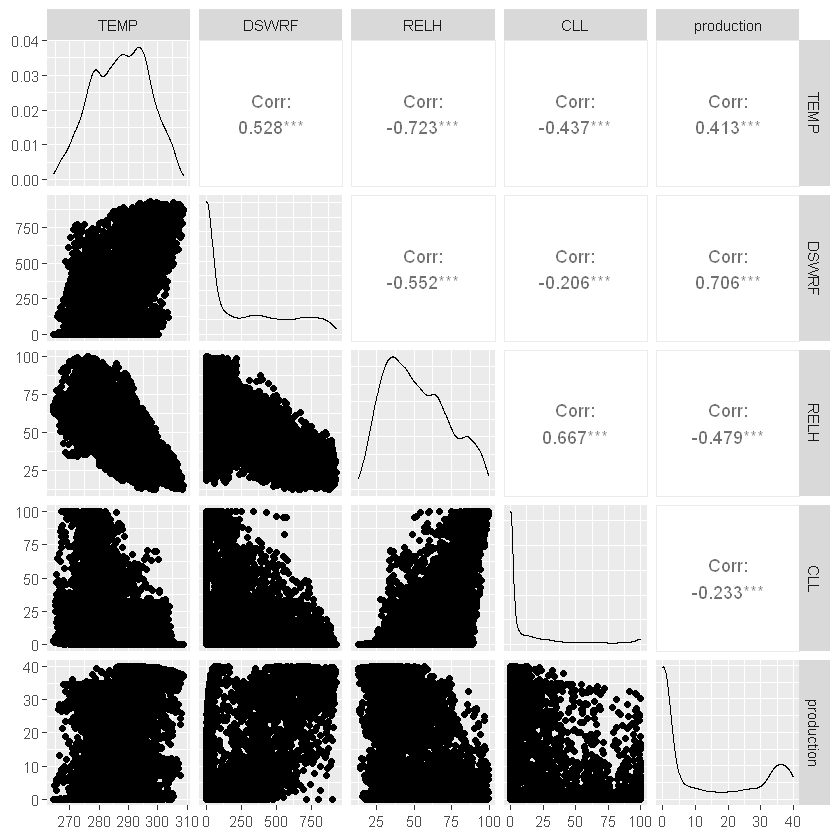

In [13]:
ggpairs(dt[, c("TEMP", "DSWRF", "RELH", "CLL", "production")])

In [14]:
dt[, DSWRF_above := ifelse(DSWRF > 300, DSWRF, 0)]

dt[, TEMP_above := ifelse(TEMP > 302, TEMP, 0)]

dt[, RELH_above := ifelse(RELH > 75, RELH, 0)]

dt[, CLL_above := ifelse(CLL > 40, CLL, 0)]


In [15]:
dt[, CLL_lag1 := shift(CLL)]
dt[, RELH_lag1 := shift(RELH)]
dt[, DSWRF_lag1 := shift(DSWRF)]
dt[, TEMP_lag1 := shift(TEMP)]

dt[, CLL_lag2 := shift(CLL_lag1)]
dt[, RELH_lag2 := shift(RELH_lag1)]
dt[, DSWRF_lag2 := shift(DSWRF_lag1)]
dt[, TEMP_lag2 := shift(TEMP_lag1)]

dt[, CLL_lag3 := shift(CLL_lag2)]
dt[, RELH_lag3 := shift(RELH_lag2)]
dt[, DSWRF_lag3 := shift(DSWRF_lag2)]
dt[, TEMP_lag3 := shift(TEMP_lag2)]

dt[, CLL_lag4 := shift(CLL_lag3)] 
dt[, RELH_lag4 := shift(RELH_lag3)]
dt[, DSWRF_lag4 := shift(DSWRF_lag3)]
dt[, TEMP_lag4 := shift(TEMP_lag3)]

dt[, CLL_next1 := shift(CLL, -1)]
dt[, RELH_next1 := shift(RELH, -1)]
dt[, DSWRF_next1 := shift(DSWRF, -1)]
dt[, TEMP_next1 := shift(TEMP, -1)]

dt[, CLL_next2 := shift(CLL, -2)]
dt[, RELH_next2 := shift(RELH, -2)]
dt[, DSWRF_next2 := shift(DSWRF, -2)]
dt[, TEMP_next2 := shift(TEMP, -2)]

dt[, CLL_next3 := shift(CLL, -3)]
dt[, RELH_next3 := shift(RELH, -3)]
dt[, DSWRF_next3 := shift(DSWRF, -3)]
dt[, TEMP_next3 := shift(TEMP, -3)]

dt[, CLL_mean11 := frollmean(CLL, 11, align="center", na.rm=T)]
dt[, RELH_mean11 := frollmean(RELH, 11, align="center", na.rm=T)]
dt[, RELH_l8h := frollmean(RELH, 8, align="right", na.rm=T)]

In [16]:
for (h in 0:23){
    print(paste("Maximum production at hour ", h, ": ", max(dt[hour == h, production], na.rm = T)))
}

# There is just one day that has nonzero production at hour = 20. So, it can be assumed to be 0 while forecasting. 
table(dt[hour == 20, production])


[1] "Maximum production at hour  0 :  0"
[1] "Maximum production at hour  1 :  0"
[1] "Maximum production at hour  2 :  0"
[1] "Maximum production at hour  3 :  0"
[1] "Maximum production at hour  4 :  0"
[1] "Maximum production at hour  5 :  0.251"
[1] "Maximum production at hour  6 :  7.97"
[1] "Maximum production at hour  7 :  27.84"
[1] "Maximum production at hour  8 :  39.62"
[1] "Maximum production at hour  9 :  39.878723"
[1] "Maximum production at hour  10 :  39.878"
[1] "Maximum production at hour  11 :  39.878"
[1] "Maximum production at hour  12 :  39.847"
[1] "Maximum production at hour  13 :  39.88"
[1] "Maximum production at hour  14 :  39.847"
[1] "Maximum production at hour  15 :  39.72"
[1] "Maximum production at hour  16 :  39.217"
[1] "Maximum production at hour  17 :  29.419"
[1] "Maximum production at hour  18 :  12.19"
[1] "Maximum production at hour  19 :  2.173"
[1] "Maximum production at hour  20 :  0.15"
[1] "Maximum production at hour  21 :  0"
[1] "Maximum p


   0 0.15 
 364    1 

In [17]:
dt_hour <- list()
for (h in 5:19){
    dt_hour[[h]] <- dt[hour == h]
    dt_hour[[h]][, capacity := frollapply(production, 30, FUN="max", align="right", na.rm=T)]
    dt_hour[[h]][, scaledprod := production/capacity]
    dt_hour[[h]][, scaledprod_lag72 := shift(scaledprod, 3)]
    dt_hour[[h]][, scaledprod_lag96 := shift(scaledprod, 4)]
    dt_hour[[h]][, scaledprod_lag120 := shift(scaledprod, 5)]
}

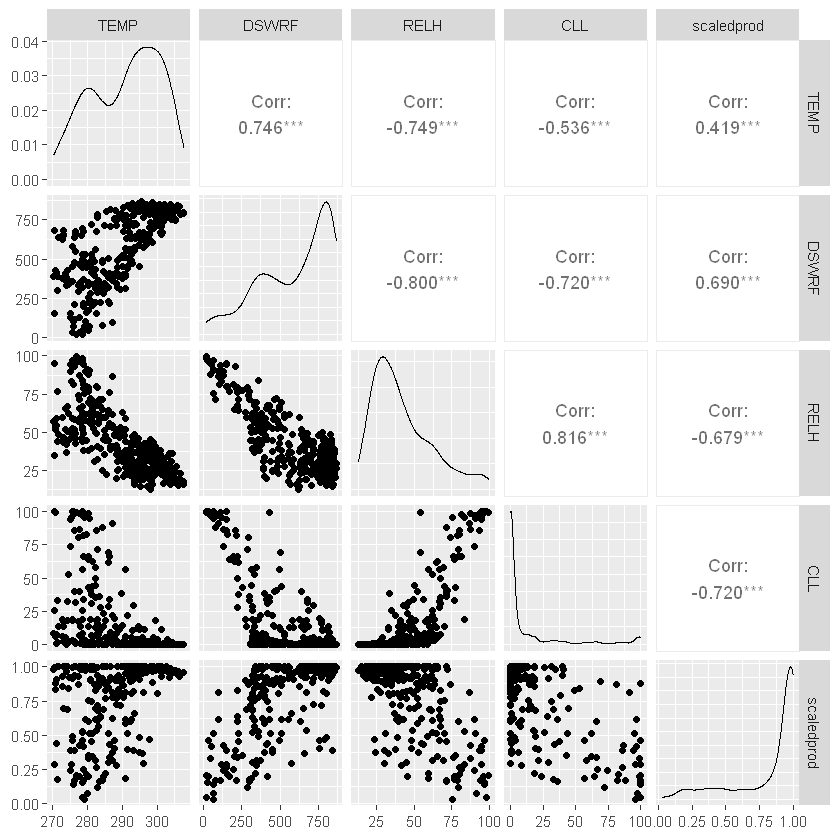

In [18]:
ggpairs(dt_hour[[12]][, c("TEMP", "DSWRF", "RELH", "CLL", "scaledprod")])

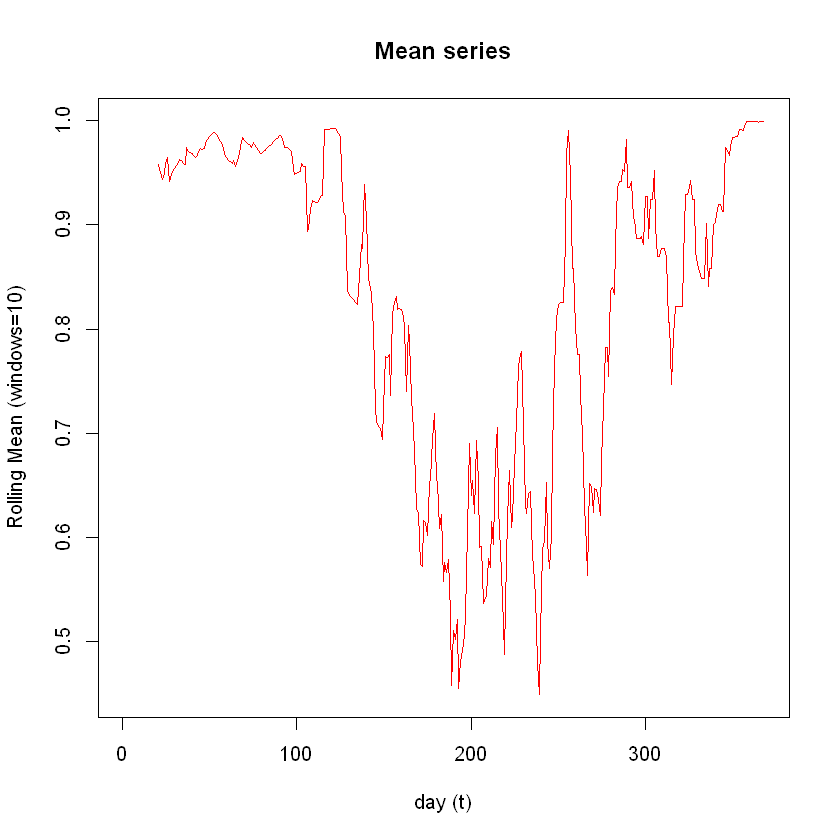

In [19]:
time_window=10
mean_series=rollmean(dt_hour[[12]]$scaledprod,time_window,align='left',na.rm= TRUE )


plot(mean_series,
     type='l',col='red',
     xlab = "day (t)",
     ylab = "Rolling Mean (windows=10)",
     main = "Mean series")

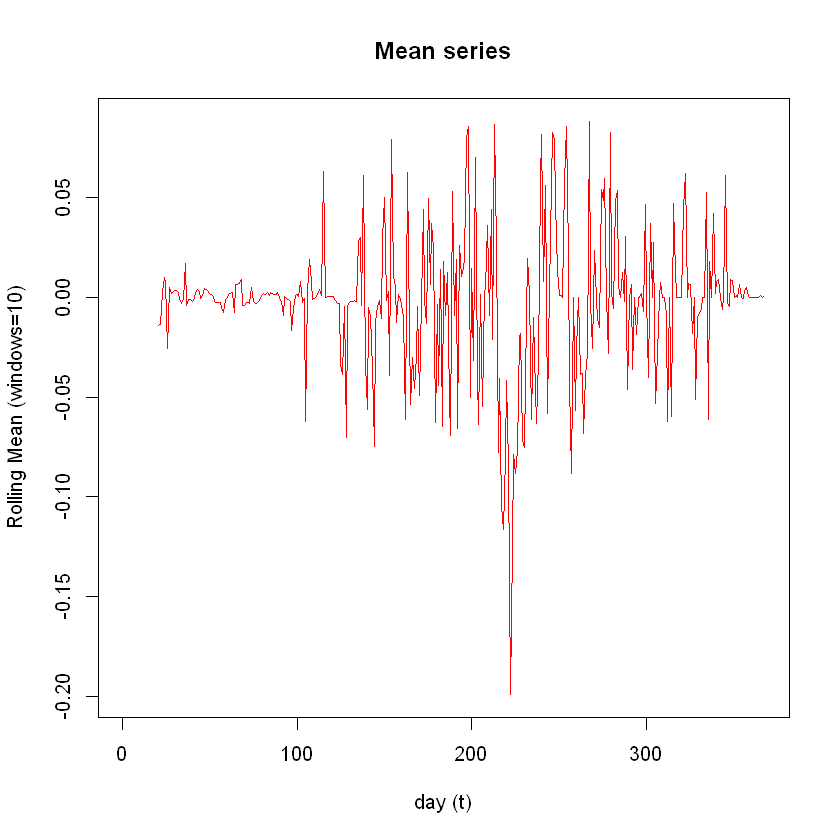

In [20]:
time_window=10
mean_series=rollmean(diff(dt_hour[[12]]$scaledprod),time_window,align='left',na.rm= TRUE )


plot(mean_series,
     type='l',col='red',
     xlab = "day (t)",
     ylab = "Rolling Mean (windows=10)",
     main = "Mean series")

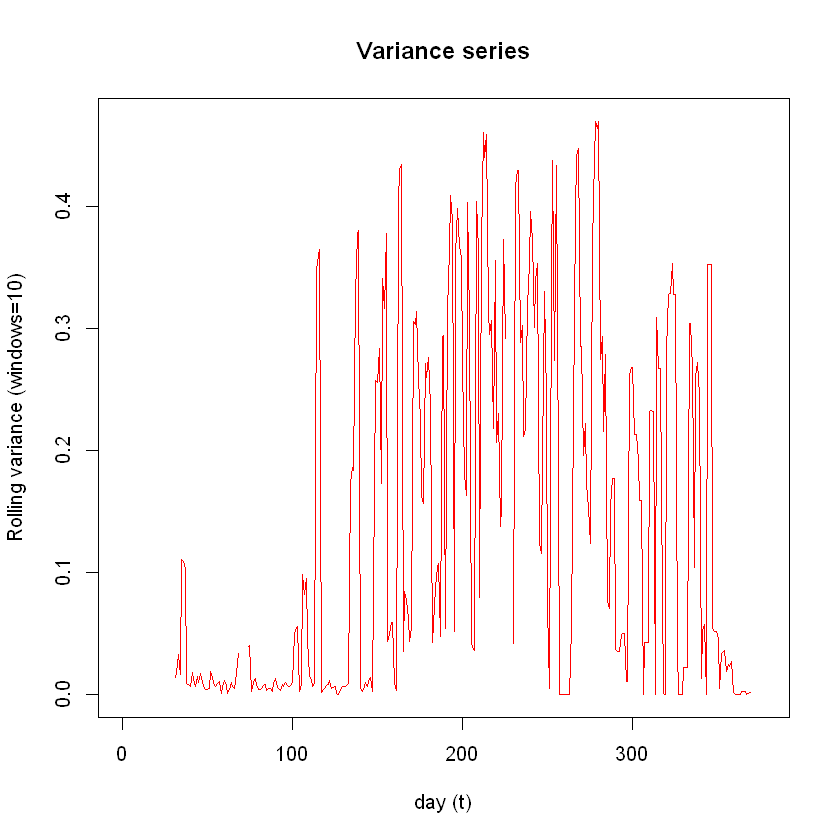

In [21]:
roll_sd= rollapply(dt_hour[[12]]$scaledprod, width = 3, FUN = sd, na.pad = TRUE)
plot(roll_sd,
     type='l',col='red',
     xlab = "day (t)",
     ylab = "Rolling variance (windows=10)",
     main = "Variance series")

In [22]:
WMAPE <- function(forecast, actual){
    n <- length(actual)
    mean <- mean(actual)
    error <- actual - forecast
    MAD <- sum(abs(error))/n
    WMAPE <- MAD/mean
    return (WMAPE)
}

In [23]:
training_Data=na.omit(dt_hour[[12]][date > "2022-03-01" &date <= "2022-06-01"])
test_Data=na.omit(dt_hour[[12]][date > "2022-06-01"])

In [24]:
training_Data

datetime,date,hour,production,CLL,DSWRF,RELH,TEMP,DSWRF_above,TEMP_above,...,DSWRF_next3,TEMP_next3,CLL_mean11,RELH_mean11,RELH_l8h,capacity,scaledprod,scaledprod_lag72,scaledprod_lag96,scaledprod_lag120
2022-03-02 12:00:00,2022-03-02,12,17.73,95.13333333,67.90444,90.64444,280.6431,0.0000,0,...,96.77556,281.1447,92.628282828,89.30000,92.49583,34.58,0.5127241,0.6148062,1.0000000,0.7440717
2022-03-03 12:00:00,2022-03-03,12,9.82,95.67777778,119.25333,83.03333,275.3678,0.0000,0,...,305.93111,276.5390,82.100000000,80.44545,89.43472,34.58,0.2839792,0.6165414,0.6148062,1.0000000
2022-03-04 12:00:00,2022-03-04,12,34.58,0.51111111,551.65111,42.95556,276.6406,551.6511,0,...,639.91778,278.6688,0.965656566,49.65657,56.11806,34.58,1.0000000,0.3157895,0.6165414,0.6148062
2022-03-05 12:00:00,2022-03-05,12,33.67,2.98888889,531.28222,62.02222,279.4218,531.2822,0,...,563.20889,280.4064,15.688888889,63.88384,62.40000,34.58,0.9736842,0.5127241,0.3157895,0.6165414
2022-03-06 12:00:00,2022-03-06,12,6.01,82.00000000,218.57778,78.45556,278.7196,0.0000,0,...,199.50444,277.5444,66.938383838,81.83535,77.82500,34.58,0.1737999,0.2839792,0.5127241,0.3157895
2022-03-07 12:00:00,2022-03-07,12,33.86,40.80000000,474.37333,72.16667,280.9547,474.3733,0,...,441.99556,280.6953,41.824242424,78.18687,76.21389,34.58,0.9791787,1.0000000,0.2839792,0.5127241
2022-03-08 12:00:00,2022-03-08,12,34.36,12.75555556,560.66889,62.01111,282.1147,560.6689,0,...,578.44889,283.1998,19.153535354,65.24444,69.05278,34.58,0.9936379,0.9736842,1.0000000,0.2839792
2022-03-09 12:00:00,2022-03-09,12,17.66,43.66666667,506.95556,69.84444,281.5250,506.9556,0,...,477.11556,281.6953,56.850505051,73.88182,77.75833,34.58,0.5106998,0.1737999,0.9736842,1.0000000
2022-03-10 12:00:00,2022-03-10,12,15.99,56.78888889,498.02444,66.88889,278.6222,498.0244,0,...,571.67556,278.8087,61.336363636,74.35152,81.64444,34.58,0.4624060,0.9791787,0.1737999,0.9736842
2022-03-11 12:00:00,2022-03-11,12,29.63,18.65555556,624.13333,59.75556,272.7333,624.1333,0,...,718.10889,273.6584,33.411111111,61.25152,70.98472,34.58,0.8568537,0.9936379,0.9791787,0.1737999



Call:
lm(formula = scaledprod ~ . - date - datetime - hour - capacity - 
    production, data = na.omit(training_Data))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41222 -0.04855  0.01092  0.06514  0.23325 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)       -0.6166194  1.8608522  -0.331    0.742
CLL               -0.0536312  0.0387450  -1.384    0.173
DSWRF             -0.0104231  0.0069366  -1.503    0.139
RELH              -0.0544037  0.0811687  -0.670    0.506
TEMP               0.0814152  0.4208383   0.193    0.847
DSWRF_above        0.0025311  0.0025082   1.009    0.318
TEMP_above         0.0001543  0.0003982   0.387    0.700
RELH_above         0.0013728  0.0046054   0.298    0.767
CLL_above         -0.0003155  0.0034575  -0.091    0.928
CLL_lag1           0.0248030  0.0245230   1.011    0.317
RELH_lag1          0.0765488  0.0675422   1.133    0.263
DSWRF_lag1         0.0042843  0.0058482   0.733    0.467
TEMP_lag1         -

[1] 0.1115348


	Breusch-Godfrey test for serial correlation of order up to 46

data:  Residuals
LM test = 87.114, df = 46, p-value = 0.0002399


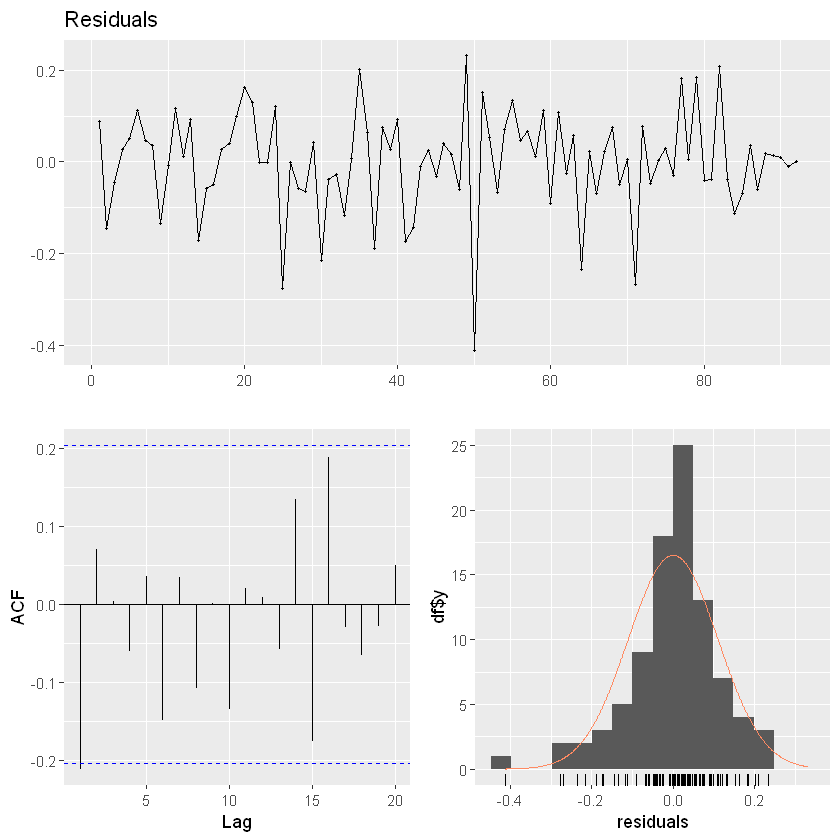

In [25]:
fit <- lm(scaledprod ~.-date-datetime-hour-capacity-production, na.omit(training_Data))
summary(fit)
predicted=pmin(pmax(0,predict(fit,test_Data))*test_Data$capacity,test_Data$capacity)
WMAPE(test_Data$production, predicted)
checkresiduals(fit)
 


Call:
lm(formula = scaledprod ~ . - date - datetime - hour - capacity - 
    production - TEMP - TEMP_lag1 - TEMP_lag2 - TEMP_lag3 - TEMP_lag4 - 
    TEMP_above - RELH_next3 - TEMP_next1 - CLL_next1 - CLL_next2 - 
    scaledprod_lag72 - CLL_lag2 - RELH_l8h - DSWRF_next2 - RELH_mean11 - 
    production - CLL_lag1 - scaledprod_lag96 - scaledprod_lag120 - 
    DSWRF_next3 - CLL - CLL_next3 - DSWRF_above - TEMP_above - 
    RELH_above - CLL_above - DSWRF - DSWRF_lag1 - DSWRF_lag2 - 
    DSWRF_lag3 - DSWRF_lag4, data = na.omit(training_Data))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51443 -0.03433  0.02856  0.08990  0.26870 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.5500894  1.0467180   1.481  0.14266    
RELH        -0.0416285  0.0314837  -1.322  0.18996    
RELH_lag1    0.0633113  0.0310263   2.041  0.04468 *  
RELH_lag2   -0.0233250  0.0236660  -0.986  0.32738    
CLL_lag3     0.0161207  0.0154686   1.042  0.30056    
RELH_l

[1] 0.09753218


	Breusch-Godfrey test for serial correlation of order up to 17

data:  Residuals
LM test = 12.128, df = 17, p-value = 0.7923


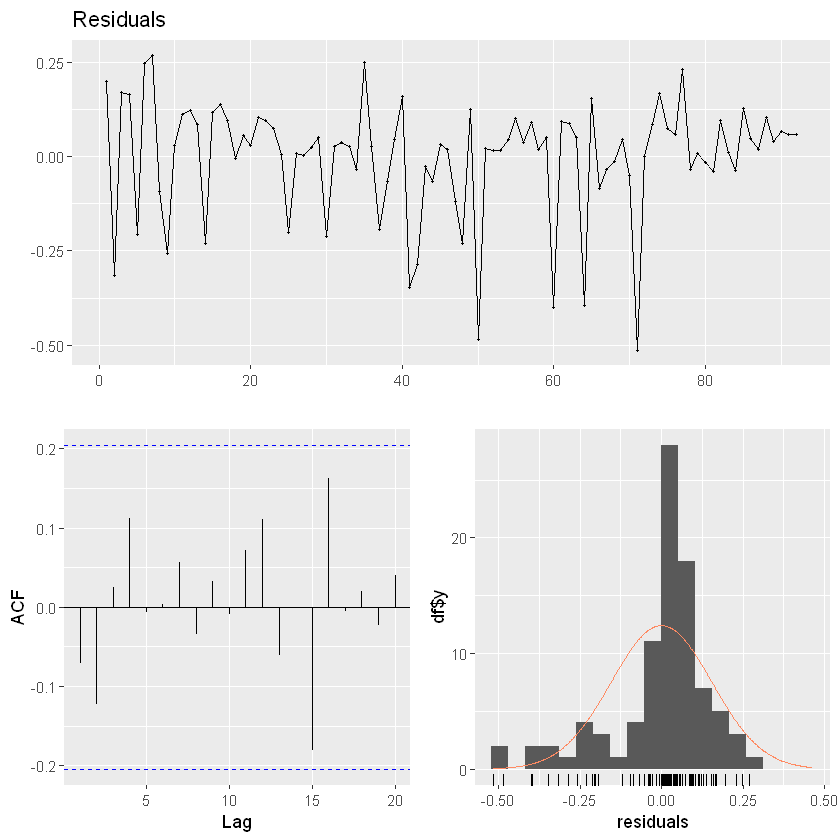

In [26]:
fit <- lm(scaledprod ~.-date-datetime-hour-capacity-production-TEMP-TEMP_lag1-TEMP_lag2-TEMP_lag3-TEMP_lag4-TEMP_above-RELH_next3-TEMP_next1-CLL_next1-CLL_next2-scaledprod_lag72-CLL_lag2-RELH_l8h-DSWRF_next2-RELH_mean11-production-CLL_lag1-scaledprod_lag96-scaledprod_lag120-DSWRF_next3-CLL-CLL_next3-DSWRF_above-TEMP_above-RELH_above-CLL_above-DSWRF-DSWRF_lag1-DSWRF_lag2-DSWRF_lag3-DSWRF_lag4, na.omit(training_Data))
summary(fit)
predicted=pmin(pmax(0,predict(fit,test_Data))*test_Data$capacity,test_Data$capacity)
WMAPE(test_Data$production, predicted)
checkresiduals(fit)
 

#### ACF of residuals seems pretty good with no significant spikes. Besides, residuals have constant variance and mean around 0. Time series of residuals seem to show stationarity. Fitting residuals with arima model might give us usefull insights about the residual behaviour.

In [27]:
arima.fit <- auto.arima(fit$residuals, trace = TRUE)
summary(arima.fit)
 


 ARIMA(2,0,2) with non-zero mean : -73.22277
 ARIMA(0,0,0) with non-zero mean : -79.52142
 ARIMA(1,0,0) with non-zero mean : -77.85248
 ARIMA(0,0,1) with non-zero mean : -78.00447
 ARIMA(0,0,0) with zero mean     : -81.6118
 ARIMA(1,0,1) with non-zero mean : -76.2102

 Best model: ARIMA(0,0,0) with zero mean     

Series: fit$residuals 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.02358:  log likelihood=41.83
AIC=-81.66   AICc=-81.61   BIC=-79.13

Training set error measures:
                       ME     RMSE       MAE MPE MAPE      MASE        ACF1
Training set 2.600759e-19 0.153571 0.1087258 100  100 0.7090038 -0.07098518


#### Residuals have simply white noise characteristics according to the ARIMA(0,0,0) model. Before finalizing the model selection, we will try to use ARIMA model for the production prediction. Here, WMAPE is computed by the training data.

In [28]:
arima.fit <- auto.arima(training_Data[,scaledprod], trace = TRUE, max.p = 20,max.q = 20)
summary(arima.fit)
(sum(abs(arima.fit$residuals))/nrow(training_Data))/mean(training_Data$scaledprod) 


 ARIMA(2,1,2) with drift         : -20.31947
 ARIMA(0,1,0) with drift         : 32.20514
 ARIMA(1,1,0) with drift         : 11.14332
 ARIMA(0,1,1) with drift         : Inf
 ARIMA(0,1,0)                    : 30.14645
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(2,1,1) with drift         : -22.37311
 ARIMA(1,1,1) with drift         : Inf
 ARIMA(2,1,0) with drift         : -9.053327
 ARIMA(3,1,1) with drift         : Inf
 ARIMA(3,1,0) with drift         : -15.22603
 ARIMA(3,1,2) with drift         : Inf
 ARIMA(2,1,1)                    : -23.21047
 ARIMA(1,1,1)                    : -22.54609
 ARIMA(2,1,0)                    : -11.0185
 ARIMA(3,1,1)                    : -21.34853
 ARIMA(2,1,2)                    : -21.1295
 ARIMA(1,1,0)                    : 9.125692
 ARIMA(1,1,2)                    : -21.69532
 ARIMA(3,1,0)                    : -17.15878
 ARIMA(3,1,2)                    : -19.3852

 Best model: ARIMA(2,1,1)                    

Series: training_Data[, scaledprod] 
ARIMA(

[1] 0.1719096

In [29]:
forecast_with_lr <- function(fmla, hourly_data, test_start_date, test_end_date, whole_data) {
    # fmla should be passed as a string vector for customized linear regression models for each hour.
    test_start_date <- as.Date(test_start_date)
    test_end_date <- as.Date(test_end_date)
    dt_train <- list()
    models <- list()
    for (h in 5:19){
        dt_train[[h]] <- na.omit(hourly_data[[h]][date < test_start_date])
        models[[h]] <- lm(as.formula(fmla[h]), dt_train[[h]])
        print(paste("Model Outputs for hour = ", h))
        print(summary(models[[h]]))
        checkresiduals(models[[h]])
    }
    test_days <- seq(test_start_date, test_end_date, by=1)
    dt_test <- data.frame(matrix(ncol = 4, nrow = 0))
    cols <- c("date", "hour", "forecast", "actual")
    colnames(dt_test) <- cols
    for (test_date in test_days){
        for (h in 0:23){
            if((h < 5) | (h > 19)){
                actual <- whole_data[(date == test_date) & (hour == h), production]
                dt_test[nrow(dt_test)+1,] <- c(format(as.Date(test_date,origin="1970-01-01")), h, 0, actual)
            }
            else {
                capacity <- hourly_data[[h]][(date == test_date), capacity]
                forecast <- pmin(pmax(0, predict(models[[h]], hourly_data[[h]][date == test_date]))*capacity, capacity)
                actual <- hourly_data[[h]][date == test_date, production]
                dt_test[nrow(dt_test)+1,] <- c(format(as.Date(test_date,origin="1970-01-01")), h, forecast, actual)
            }
        }
    }
    dt_test$forecast <- as.numeric(dt_test$forecast)
    dt_test$actual <- as.numeric(dt_test$actual)
    print(c(WMAPE = WMAPE(dt_test$forecast, dt_test$actual)))
    return(dt_test)
}

[1] "Model Outputs for hour =  5"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.155781 -0.028399 -0.006328  0.034472  0.098886 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.715066   2.369486   1.568  0.12645    
RELH         0.060323   0.029786   2.025  0.05100 .  
RELH_lag1   -0.056386   0.026486  -2.129  0.04082 *  
RELH_lag2    0.015213   0.022070   0.689  0.49545    
CLL_lag3     0.077666   0.088814   0.874  0.38818    
RELH_lag3   -0.003890   0.035739  -0.109  0.91399    
CLL_lag4     0.024877   0.078663   0.316  0.75381    
RELH_lag4    0.002501   0.021762   0.115  0.90920    
RELH_next1  -0.028590   0.021918  -1.304  0.20111    
DSWRF_next1  0.522588   0.038350  13.627 4.18e-15 ***
RELH_next2   0.011398   0.010535   1.082  0.28713    
TEMP_next2   0.026618   0.026787   0.994  0.32761    
TEMP_next3  -0.038768   0.026236  -1.478  0.14898    
CLL_mean11  -0.259

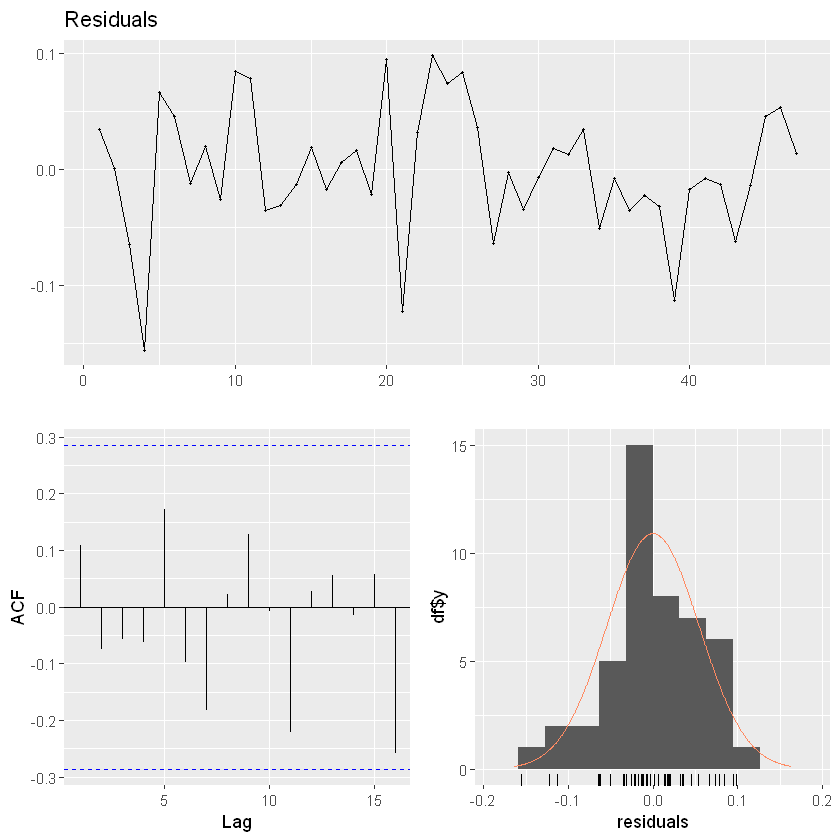

[1] "Model Outputs for hour =  7"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5670 -0.1253 -0.0025  0.0834  0.7218 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.7079501  1.2838993   3.667 0.000311 ***
RELH         0.0415320  0.0154939   2.681 0.007931 ** 
RELH_lag1   -0.0219507  0.0265451  -0.827 0.409216    
RELH_lag2   -0.0125690  0.0371585  -0.338 0.735507    
CLL_lag3     0.0023692  0.0023979   0.988 0.324275    
RELH_lag3    0.0263813  0.0285139   0.925 0.355915    
CLL_lag4    -0.0008599  0.0014180  -0.606 0.544877    
RELH_lag4   -0.0068727  0.0109133  -0.630 0.529537    
RELH_next1  -0.0495263  0.0115462  -4.289 2.73e-05 ***
DSWRF_next1  0.0108539  0.0015300   7.094 1.94e-11 ***
RELH_next2   0.0226581  0.0074233   3.052 0.002563 ** 
TEMP_next2  -0.0013898  0.0525554  -0.026 0.978929    
TEMP_next3  -0.0137537  0.0539201  -0.255 0.798913    
CLL_mean11  -0.0065865  

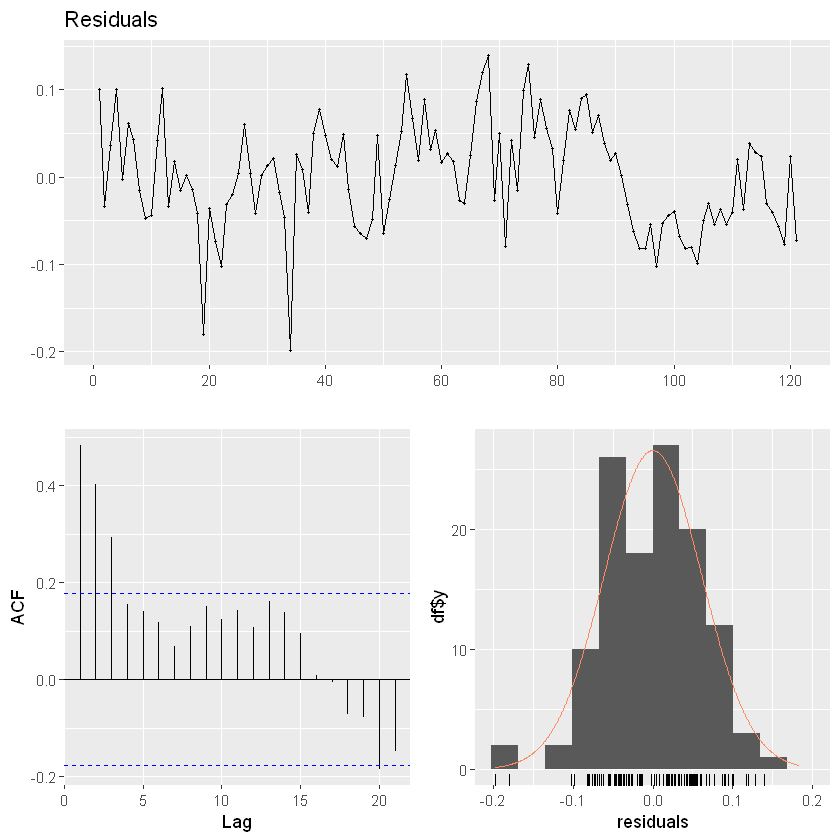

[1] "Model Outputs for hour =  8"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50880 -0.08925  0.02228  0.09411  0.71618 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.4962642  1.0348241   6.278 1.93e-09 ***
RELH        -0.0303025  0.0099053  -3.059  0.00251 ** 
RELH_lag1    0.0415701  0.0114625   3.627  0.00036 ***
RELH_lag2   -0.0309963  0.0202229  -1.533  0.12684    
CLL_lag3     0.0062393  0.0054910   1.136  0.25713    
RELH_lag3   -0.0013743  0.0271215  -0.051  0.95963    
CLL_lag4    -0.0073448  0.0045779  -1.604  0.11012    
RELH_lag4    0.0122517  0.0142882   0.857  0.39216    
RELH_next1   0.0030301  0.0099275   0.305  0.76050    
DSWRF_next1  0.0065716  0.0007719   8.513 3.17e-15 ***
RELH_next2   0.0034264  0.0060665   0.565  0.57281    
TEMP_next2  -0.0238206  0.0541018  -0.440  0.66018    
TEMP_next3   0.0029212  0.0550958   0.053  0.95777    
CLL_mean11  -0

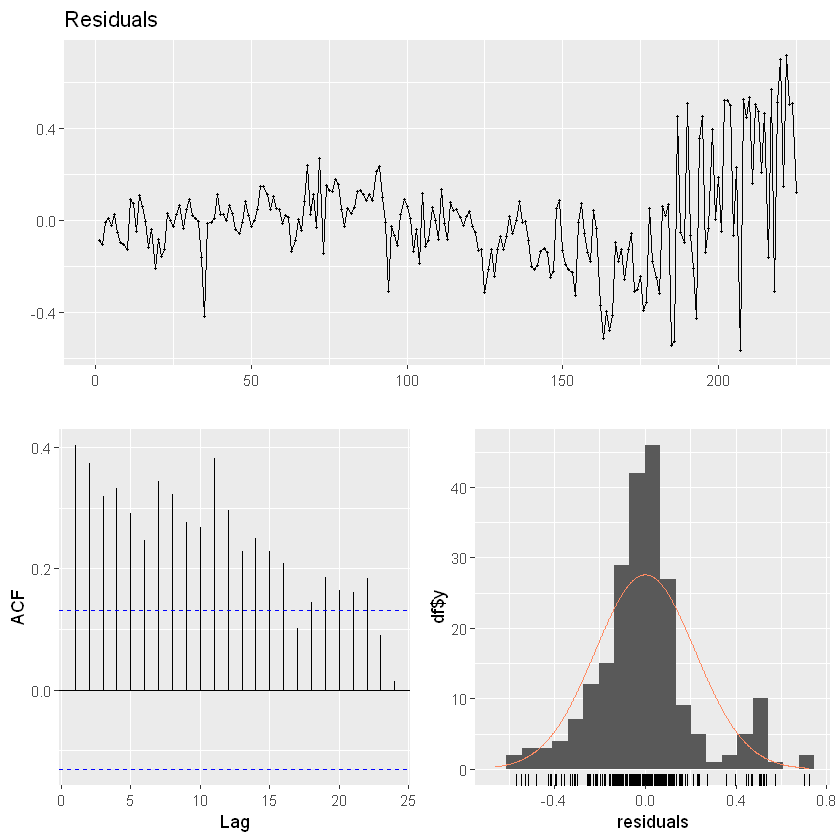

[1] "Model Outputs for hour =  9"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.71622 -0.04731  0.01835  0.09650  0.61297 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.799684   0.925834   6.264 2.07e-09 ***
RELH         0.002255   0.011120   0.203   0.8395    
RELH_lag1   -0.010667   0.009984  -1.068   0.2866    
RELH_lag2    0.019522   0.010851   1.799   0.0734 .  
CLL_lag3     0.002406   0.006193   0.388   0.6981    
RELH_lag3   -0.015519   0.015901  -0.976   0.3302    
CLL_lag4    -0.006378   0.005082  -1.255   0.2109    
RELH_lag4    0.005069   0.010196   0.497   0.6196    
RELH_next1  -0.009825   0.015936  -0.616   0.5382    
DSWRF_next1  0.001419   0.000194   7.311 5.41e-12 ***
RELH_next2   0.005838   0.009665   0.604   0.5465    
TEMP_next2  -0.030766   0.053942  -0.570   0.5690    
TEMP_next3   0.012112   0.054680   0.222   0.8249    
CLL_mean11  -0.000302   0.00

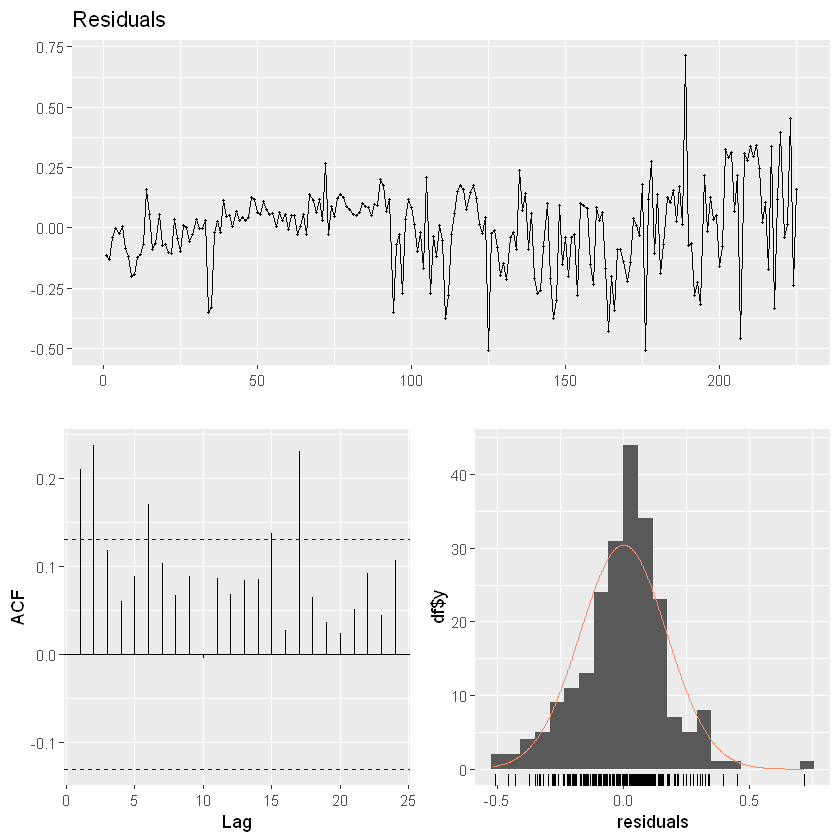

[1] "Model Outputs for hour =  10"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72674 -0.05385  0.02774  0.08171  0.43348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.1181782  0.9109360   5.619 6.04e-08 ***
RELH        -0.0109636  0.0190468  -0.576   0.5655    
RELH_lag1   -0.0074813  0.0114511  -0.653   0.5143    
RELH_lag2    0.0057533  0.0102075   0.564   0.5736    
CLL_lag3     0.0091036  0.0066851   1.362   0.1747    
RELH_lag3    0.0026421  0.0098369   0.269   0.7885    
CLL_lag4    -0.0120416  0.0057010  -2.112   0.0358 *  
RELH_lag4   -0.0028573  0.0064202  -0.445   0.6567    
RELH_next1   0.0317280  0.0231978   1.368   0.1729    
DSWRF_next1  0.0012437  0.0001831   6.792 1.10e-10 ***
RELH_next2  -0.0211051  0.0124891  -1.690   0.0925 .  
TEMP_next2  -0.0211209  0.0542497  -0.389   0.6974    
TEMP_next3   0.0047220  0.0550120   0.086   0.9317    
CLL_mean11  -

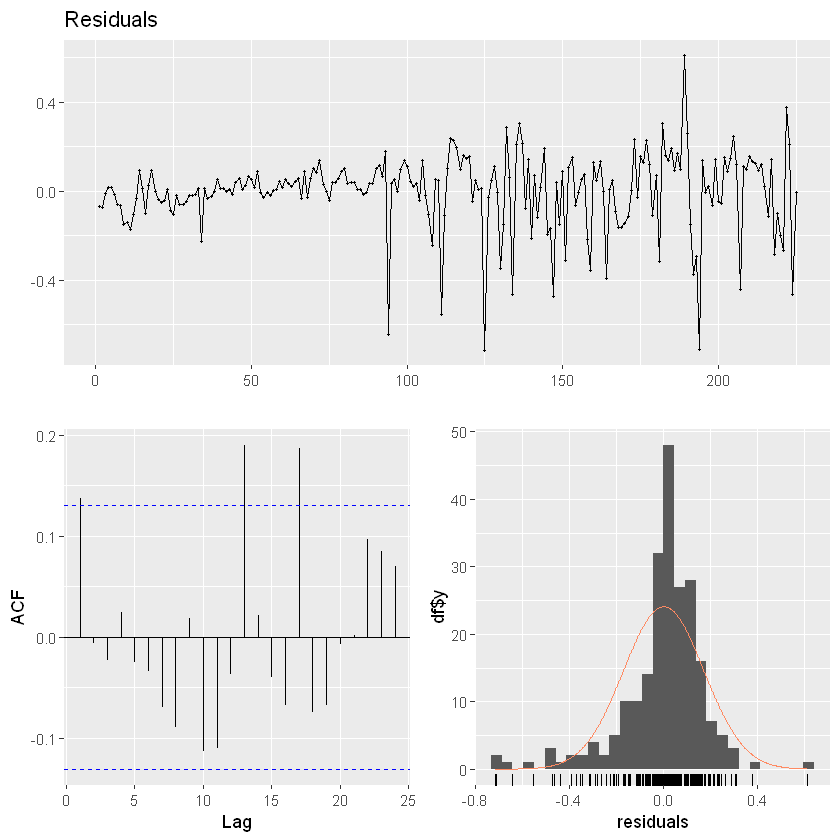

[1] "Model Outputs for hour =  11"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53975 -0.04491  0.01170  0.07073  0.43304 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.1229783  0.7314783   5.637 5.52e-08 ***
RELH         0.0560815  0.0197265   2.843  0.00491 ** 
RELH_lag1   -0.0354736  0.0153863  -2.306  0.02211 *  
RELH_lag2    0.0085570  0.0091547   0.935  0.35100    
CLL_lag3     0.0101479  0.0061891   1.640  0.10257    
RELH_lag3   -0.0073514  0.0080465  -0.914  0.36197    
CLL_lag4    -0.0100458  0.0055833  -1.799  0.07341 .  
RELH_lag4    0.0058681  0.0041493   1.414  0.15877    
RELH_next1  -0.0344386  0.0191679  -1.797  0.07382 .  
DSWRF_next1  0.0007644  0.0001371   5.574 7.56e-08 ***
RELH_next2   0.0048483  0.0102223   0.474  0.63578    
TEMP_next2  -0.1391519  0.0420354  -3.310  0.00110 ** 
TEMP_next3   0.1267257  0.0425745   2.977  0.00326 ** 
CLL_mean11  -

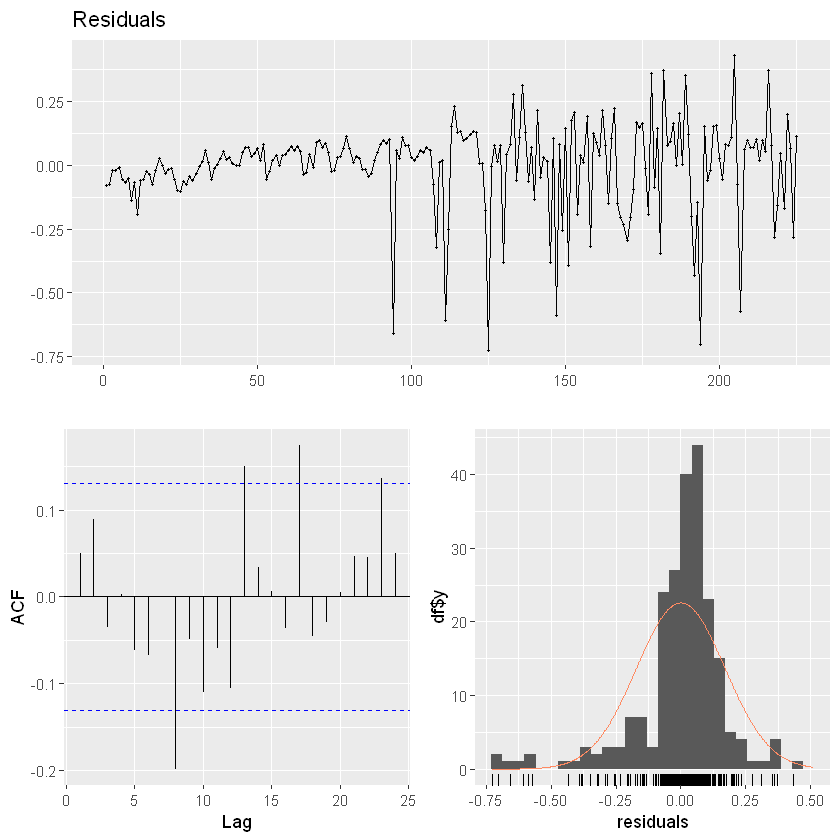

[1] "Model Outputs for hour =  12"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.55651 -0.05552  0.01707  0.06534  0.35301 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.0790641  0.7464193   5.465 1.30e-07 ***
RELH        -0.0554047  0.0202676  -2.734 0.006795 ** 
RELH_lag1    0.0601686  0.0198766   3.027 0.002776 ** 
RELH_lag2   -0.0380670  0.0156036  -2.440 0.015528 *  
CLL_lag3     0.0041079  0.0079942   0.514 0.607886    
RELH_lag3    0.0061861  0.0079069   0.782 0.434870    
CLL_lag4    -0.0041177  0.0071726  -0.574 0.566521    
RELH_lag4    0.0013339  0.0040292   0.331 0.740933    
RELH_next1   0.0614800  0.0198054   3.104 0.002170 ** 
DSWRF_next1  0.0007732  0.0001347   5.739 3.29e-08 ***
RELH_next2  -0.0381863  0.0103507  -3.689 0.000286 ***
TEMP_next2  -0.0649360  0.0420336  -1.545 0.123879    
TEMP_next3   0.0528342  0.0428498   1.233 0.218944    
CLL_mean11  -

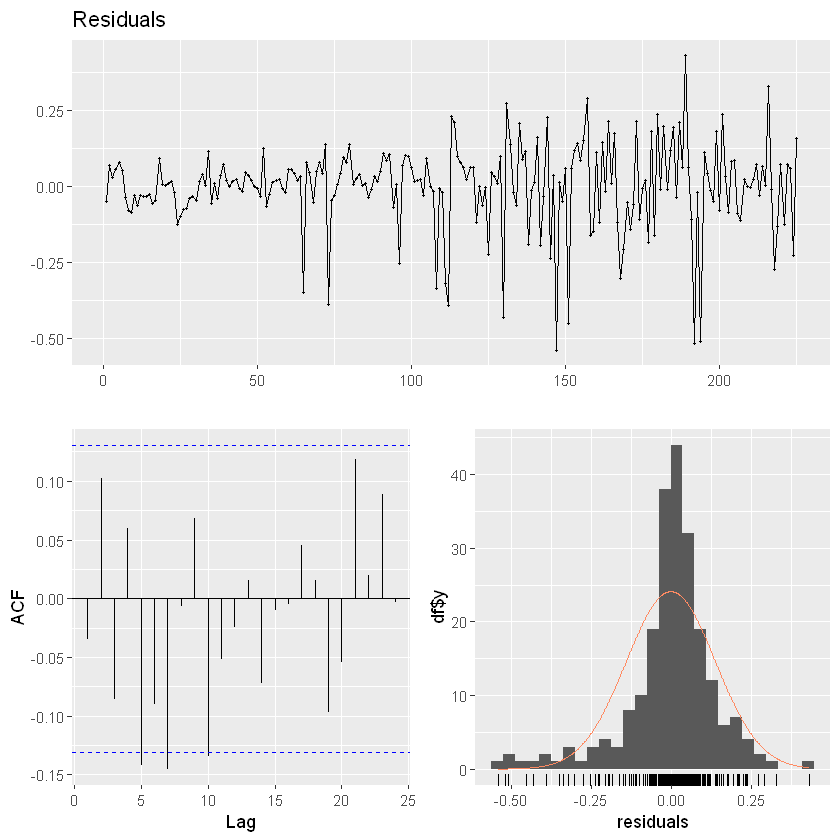

[1] "Model Outputs for hour =  13"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58549 -0.05257  0.02260  0.08032  0.46059 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.3354906  0.7673816   5.650 5.16e-08 ***
RELH         0.0241160  0.0220925   1.092   0.2763    
RELH_lag1   -0.0264996  0.0218639  -1.212   0.2269    
RELH_lag2    0.0249479  0.0209794   1.189   0.2357    
CLL_lag3     0.0009024  0.0016157   0.559   0.5771    
RELH_lag3   -0.0112570  0.0163835  -0.687   0.4928    
CLL_lag4    -0.0007664  0.0012652  -0.606   0.5453    
RELH_lag4   -0.0006469  0.0067568  -0.096   0.9238    
RELH_next1   0.0132841  0.0196524   0.676   0.4998    
DSWRF_next1  0.0007318  0.0001324   5.526 9.59e-08 ***
RELH_next2  -0.0277535  0.0104798  -2.648   0.0087 ** 
TEMP_next2  -0.0042543  0.0414328  -0.103   0.9183    
TEMP_next3  -0.0084818  0.0417521  -0.203   0.8392    
CLL_mean11  -

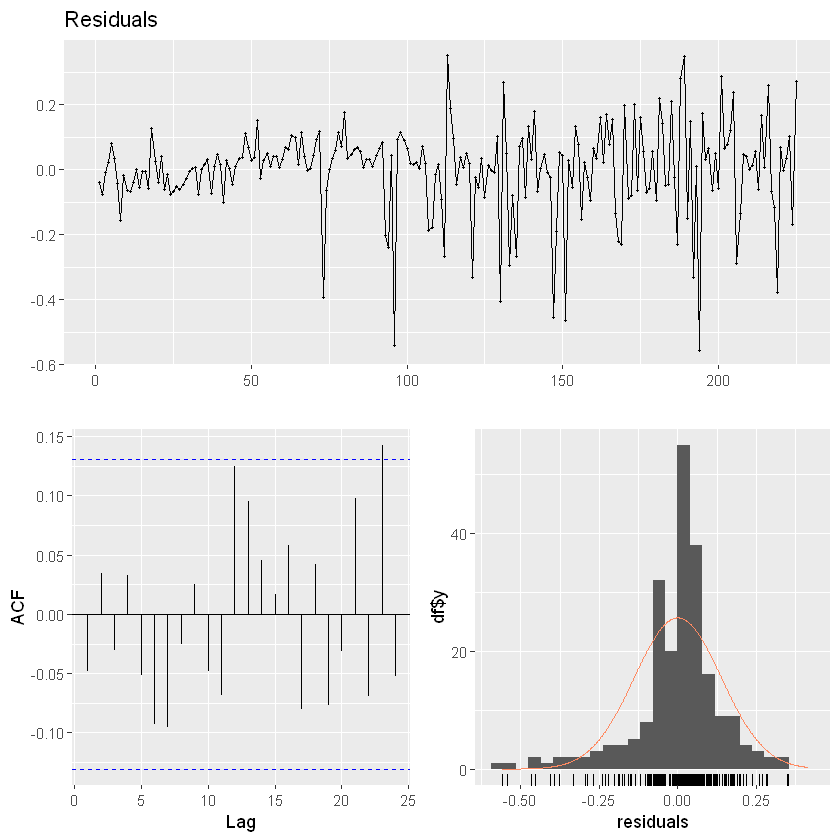

[1] "Model Outputs for hour =  14"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64127 -0.07130  0.01310  0.09498  0.58352 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.7106996  0.8563501   6.669 2.22e-10 ***
RELH         0.0316026  0.0234561   1.347 0.179326    
RELH_lag1    0.0080158  0.0251244   0.319 0.750009    
RELH_lag2   -0.0370817  0.0247151  -1.500 0.135015    
CLL_lag3     0.0115128  0.0060377   1.907 0.057904 .  
RELH_lag3    0.0389403  0.0207874   1.873 0.062414 .  
CLL_lag4    -0.0082019  0.0052473  -1.563 0.119537    
RELH_lag4   -0.0157541  0.0091603  -1.720 0.086930 .  
RELH_next1  -0.0202556  0.0175632  -1.153 0.250094    
DSWRF_next1  0.0006450  0.0001759   3.666 0.000311 ***
RELH_next2  -0.0125547  0.0075629  -1.660 0.098395 .  
TEMP_next2  -0.1009100  0.0436845  -2.310 0.021857 *  
TEMP_next3   0.0843090  0.0437893   1.925 0.055532 .  
CLL_mean11  -

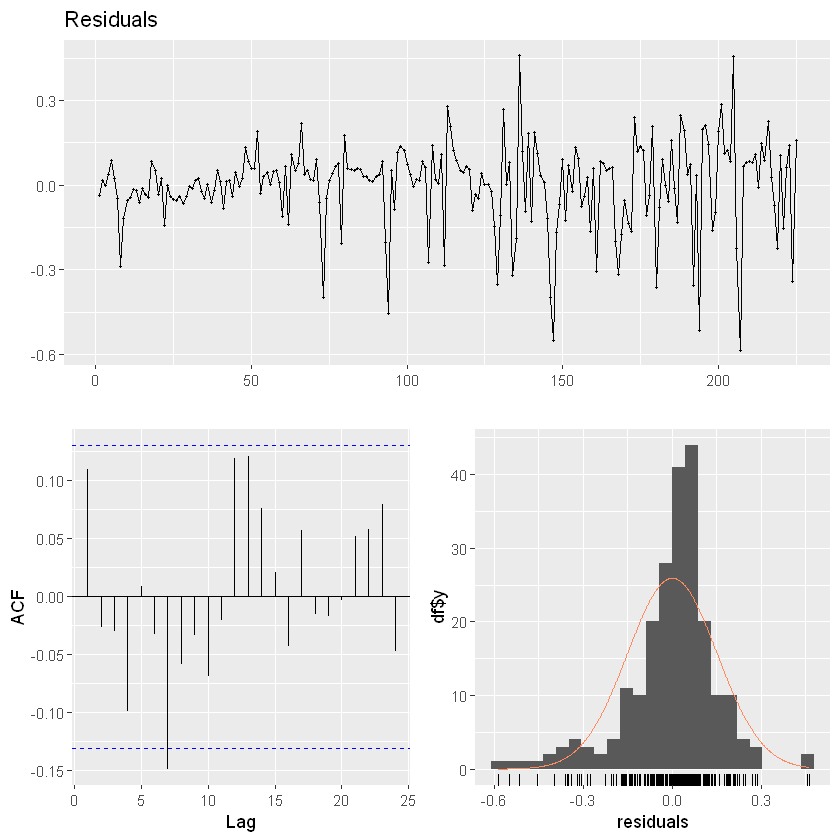

[1] "Model Outputs for hour =  15"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97744 -0.05166  0.03800  0.09875  0.64503 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.9225025  0.9955512   4.944 1.56e-06 ***
RELH        -0.0195814  0.0206894  -0.946  0.34500    
RELH_lag1    0.0413798  0.0269136   1.538  0.12567    
RELH_lag2   -0.0140317  0.0288133  -0.487  0.62677    
CLL_lag3    -0.0200482  0.0092356  -2.171  0.03107 *  
RELH_lag3    0.0027614  0.0261124   0.106  0.91588    
CLL_lag4     0.0194538  0.0081686   2.382  0.01813 *  
RELH_lag4   -0.0059142  0.0115022  -0.514  0.60766    
RELH_next1   0.0042505  0.0145175   0.293  0.76998    
DSWRF_next1  0.0004732  0.0001763   2.684  0.00786 ** 
RELH_next2  -0.0136594  0.0075231  -1.816  0.07084 .  
TEMP_next2  -0.0351145  0.0204056  -1.721  0.08675 .  
TEMP_next3   0.0213984  0.0193544   1.106  0.27015    
CLL_mean11  -

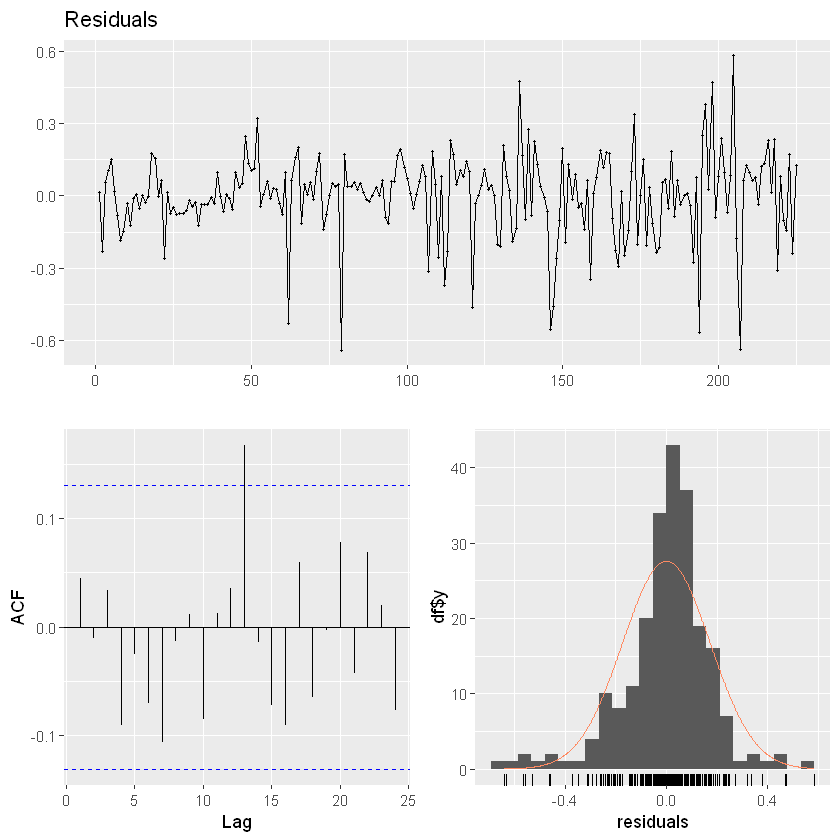

[1] "Model Outputs for hour =  16"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90556 -0.09610  0.01397  0.08789  0.79985 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.0852106  0.8979708   4.549 9.07e-06 ***
RELH        -0.0138557  0.0148640  -0.932   0.3523    
RELH_lag1   -0.0024930  0.0208958  -0.119   0.9051    
RELH_lag2    0.0191634  0.0270986   0.707   0.4802    
CLL_lag3    -0.0056348  0.0079803  -0.706   0.4809    
RELH_lag3   -0.0056956  0.0250327  -0.228   0.8202    
CLL_lag4     0.0062811  0.0068346   0.919   0.3591    
RELH_lag4    0.0014262  0.0124494   0.115   0.9089    
RELH_next1   0.0114127  0.0091419   1.248   0.2133    
DSWRF_next1  0.0010114  0.0001901   5.319 2.65e-07 ***
RELH_next2  -0.0093934  0.0047958  -1.959   0.0515 .  
TEMP_next2   0.0327506  0.0191800   1.708   0.0892 .  
TEMP_next3  -0.0458114  0.0189955  -2.412   0.0167 *  
CLL_mean11  -

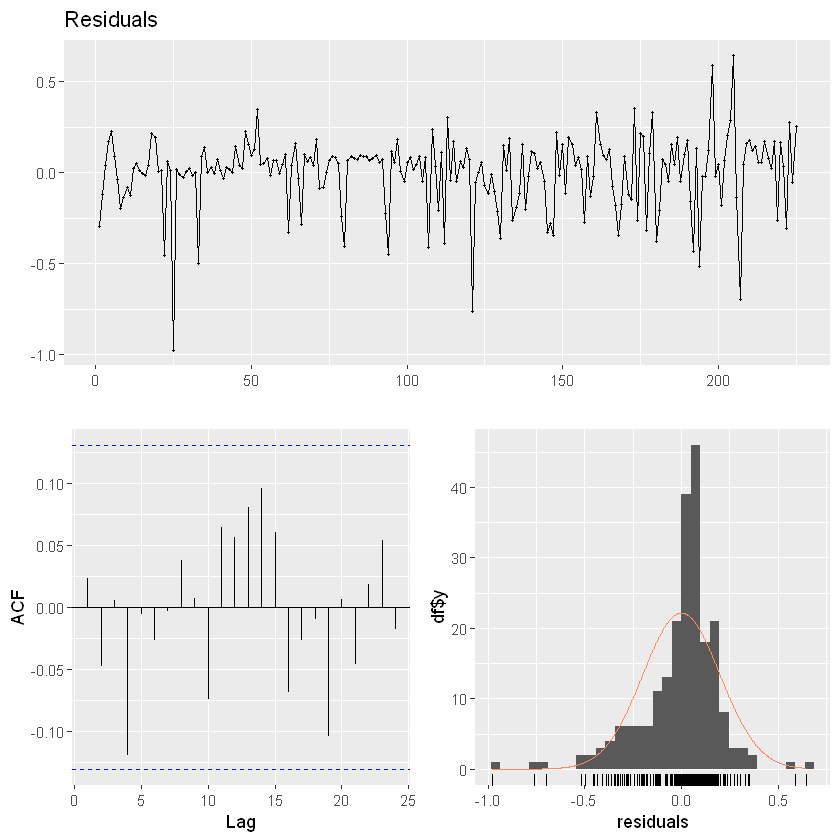

[1] "Model Outputs for hour =  17"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84867 -0.08567 -0.00060  0.09060  0.56596 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.7576643  0.9674004   5.952 1.09e-08 ***
RELH         0.0024058  0.0091807   0.262   0.7935    
RELH_lag1    0.0051823  0.0146102   0.355   0.7232    
RELH_lag2   -0.0329105  0.0201723  -1.631   0.1043    
CLL_lag3     0.0094621  0.0095054   0.995   0.3207    
RELH_lag3    0.0581502  0.0242114   2.402   0.0172 *  
CLL_lag4    -0.0071169  0.0083582  -0.851   0.3955    
RELH_lag4   -0.0242280  0.0126350  -1.918   0.0565 .  
RELH_next1   0.0030847  0.0083124   0.371   0.7109    
DSWRF_next1  0.0016810  0.0002571   6.538 4.61e-10 ***
RELH_next2  -0.0077300  0.0044904  -1.721   0.0866 .  
TEMP_next2   0.0290414  0.0299757   0.969   0.3337    
TEMP_next3  -0.0493326  0.0310557  -1.589   0.1137    
CLL_mean11  -

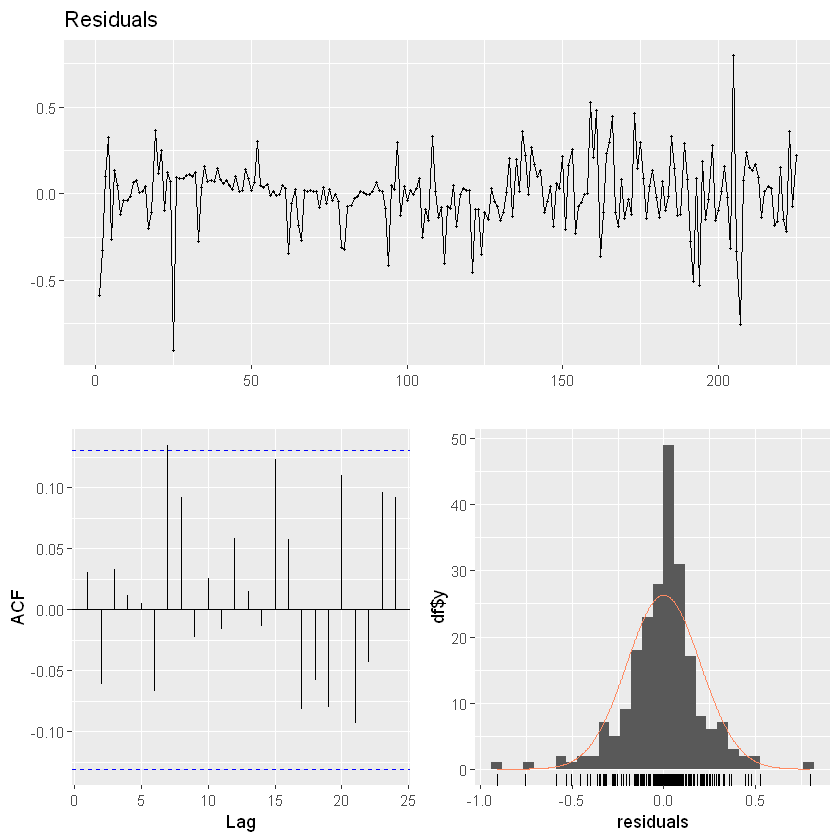

[1] "Model Outputs for hour =  18"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70976 -0.07311  0.00059  0.06794  0.59653 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.9336285  1.3175077   5.263 5.17e-07 ***
RELH         0.0228259  0.0085541   2.668  0.00851 ** 
RELH_lag1    0.0174407  0.0110565   1.577  0.11694    
RELH_lag2   -0.0486639  0.0203400  -2.393  0.01805 *  
CLL_lag3     0.0416741  0.0183050   2.277  0.02431 *  
RELH_lag3    0.0250356  0.0271558   0.922  0.35814    
CLL_lag4    -0.0387790  0.0159109  -2.437  0.01604 *  
RELH_lag4    0.0094124  0.0166304   0.566  0.57231    
RELH_next1  -0.0177655  0.0110769  -1.604  0.11099    
DSWRF_next1  0.0038474  0.0002945  13.066  < 2e-16 ***
RELH_next2  -0.0020016  0.0071936  -0.278  0.78123    
TEMP_next2  -0.1104425  0.0635491  -1.738  0.08441 .  
TEMP_next3   0.0835623  0.0636065   1.314  0.19107    
CLL_mean11  -

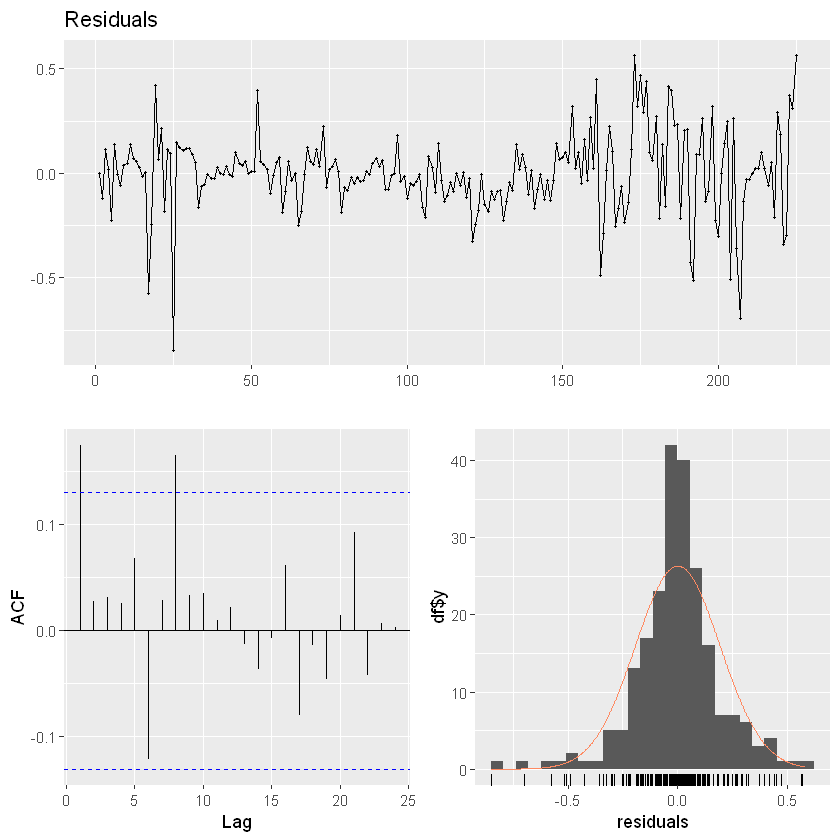

[1] "Model Outputs for hour =  19"

Call:
lm(formula = as.formula(fmla[h]), data = dt_train[[h]])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21249 -0.06903 -0.00218  0.06994  0.34489 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.2291339  2.0213985  -2.587  0.01176 *  
RELH        -0.0391711  0.0117716  -3.328  0.00140 ** 
RELH_lag1    0.0366775  0.0148152   2.476  0.01572 *  
RELH_lag2    0.0473019  0.0318563   1.485  0.14207    
CLL_lag3     0.0012523  0.0053442   0.234  0.81542    
RELH_lag3   -0.0744982  0.0292636  -2.546  0.01311 *  
CLL_lag4     0.0050882  0.0056158   0.906  0.36802    
RELH_lag4    0.0414682  0.0155400   2.668  0.00946 ** 
RELH_next1  -0.0245058  0.0129778  -1.888  0.06313 .  
DSWRF_next1  0.0021662  0.0004961   4.367 4.28e-05 ***
RELH_next2   0.0231594  0.0098009   2.363  0.02091 *  
TEMP_next2  -0.0690601  0.0665683  -1.037  0.30310    
TEMP_next3   0.0852288  0.0666932   1.278  0.20550    
CLL_mean11  -

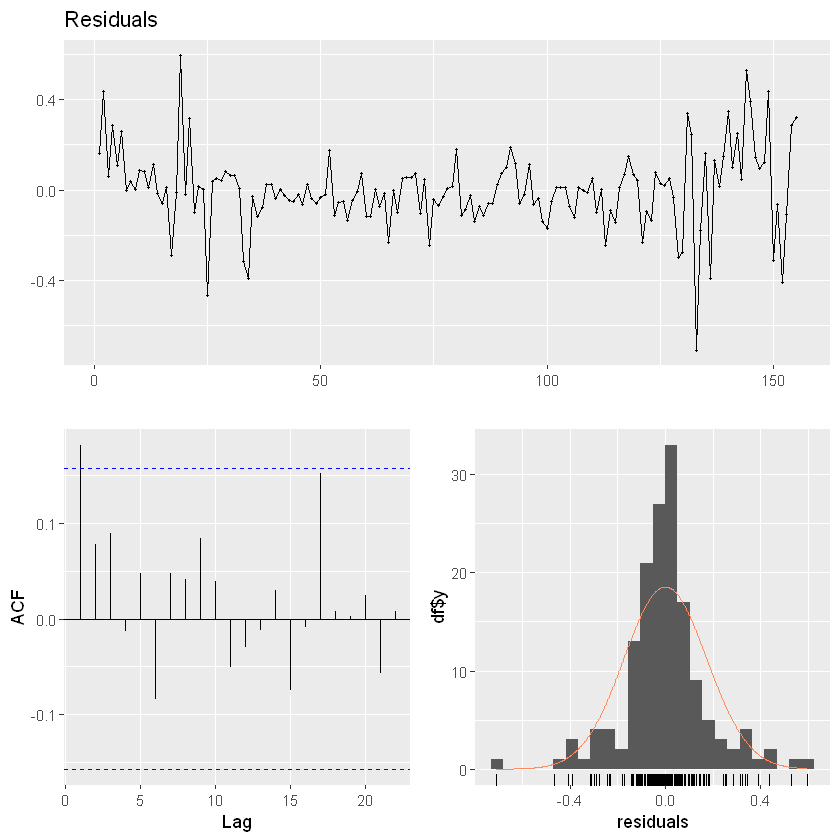

    WMAPE 
0.1301178 


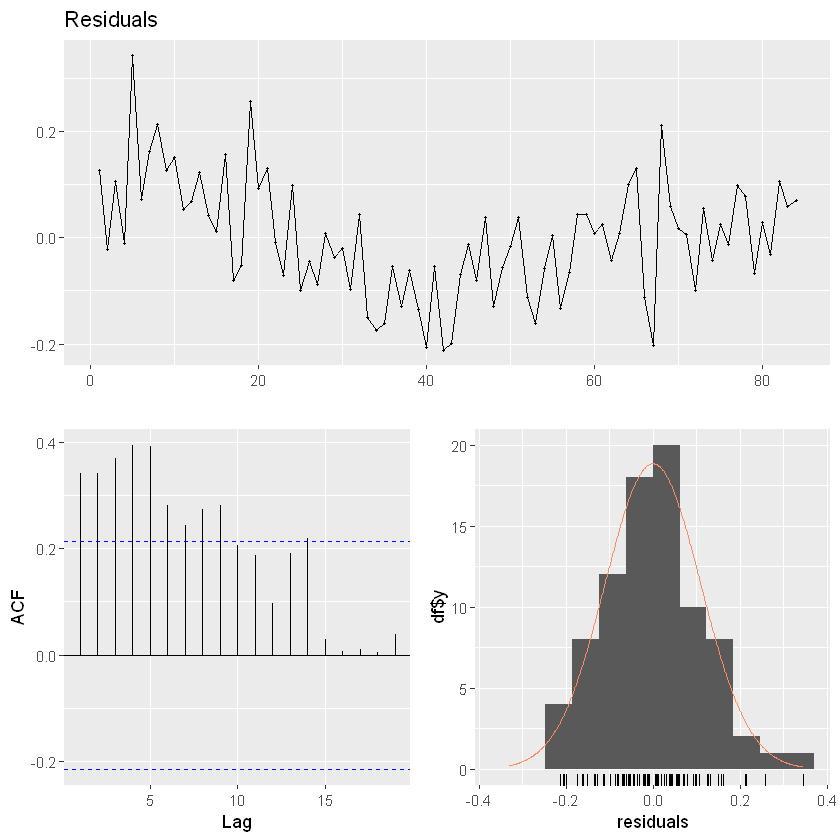

In [30]:
formulas <- rep("scaledprod ~ .-date-datetime-hour-capacity-production-TEMP-TEMP_lag1-TEMP_lag2-TEMP_lag3-TEMP_lag4-TEMP_above-RELH_next3-TEMP_next1-CLL_next1-CLL_next2-scaledprod_lag72-CLL_lag2-RELH_l8h-DSWRF_next2-RELH_mean11-production-CLL_lag1-scaledprod_lag96-scaledprod_lag120-DSWRF_next3-CLL-CLL_next3-DSWRF_above-TEMP_above-RELH_above-CLL_above-DSWRF-DSWRF_lag1-DSWRF_lag2-DSWRF_lag3-DSWRF_lag4", 23)
test_results <- forecast_with_lr(formulas, dt_hour, "2022-03-01", "2022-06-01", dt)

In [31]:
test_results=data.table(test_results)
test_results$datetime= dt[date>="2022-03-01"& date <="2022-06-01",datetime]

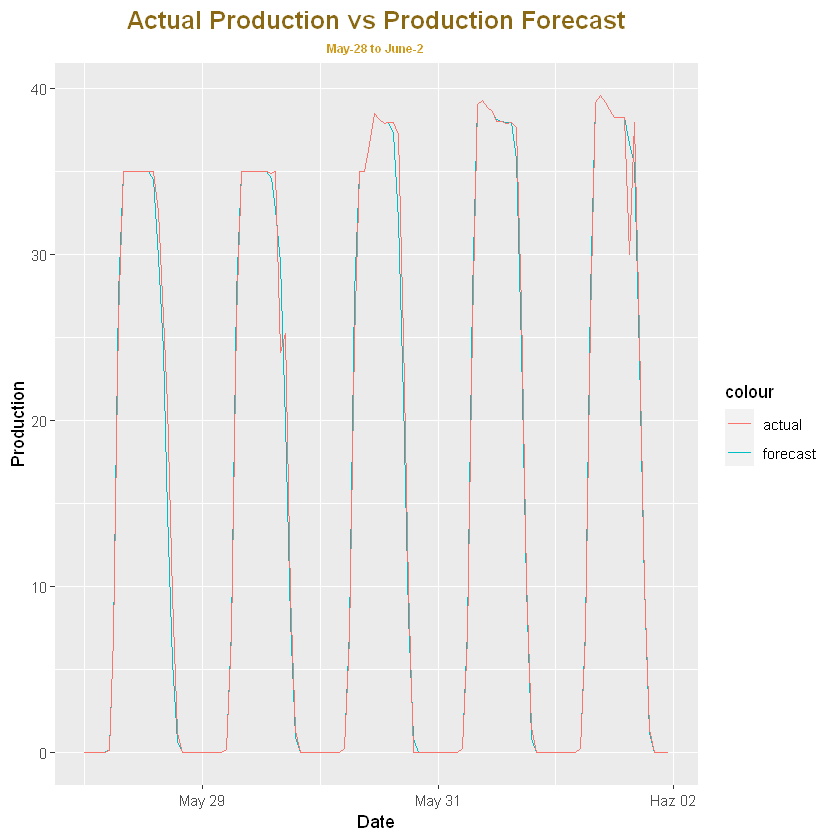

In [32]:
ggplot(tail(test_results,120), aes(x=datetime))+ geom_line(aes(y=forecast, color= "forecast"))+ geom_line(aes(y=actual , color="actual")) + 
 labs(title = "Actual Production vs Production Forecast", x = "Date",y = "Production",subtitle = "May-28 to June-2")+
  theme(plot.title = element_text(color = "goldenrod4", size = 15, face = "bold",hjust=0.5), 
  plot.subtitle = element_text(size = 7,color="goldenrod3", face = "bold", hjust = 0.5) )
 